In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from nb_002 import *

In [3]:
DATA_PATH = Path('../data')
PATH = DATA_PATH/'caltech101'
fPATH = DATA_PATH/'cifar10'

In [4]:
#export
class FilesDataset(Dataset):
    def __init__(self, fns, labels, classes=None, tfms=None):
        if classes is None: classes = list(set(labels))
        self.classes,self.tfms = classes,torchvision.transforms.Compose(tfms)
        self.class2idx = {v:k for k,v in enumerate(classes)}
        self.fns = np.array(fns)
        self.y = [self.class2idx[o] for o in labels]
        
    @classmethod
    def from_folder(cls, folder, classes=None, test_pct=0., tfms=None):
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
            
        fns,labels = [],[]
        for cl in classes:
            fnames = get_image_files(folder/cl)
            fns += fnames
            labels += [cl] * len(fnames)
            
        if test_pct==0.: return cls(fns, labels)
        fns,labels = np.array(fns),np.array(labels)
        is_test = np.random.uniform(size=(len(fns),)) < test_pct
        return cls(fns[~is_test], labels[~is_test], tfms=tfms[0]), cls(fns[is_test], labels[is_test], tfms=tfms[1])

    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        x = self.tfms(x)
        return pil2tensor(x),self.y[i]

In [5]:
sz = 224
import torchvision

In [59]:
trn_tfms = [torchvision.transforms.RandomResizedCrop(sz, scale=(0.5, 1.0)),
             torchvision.transforms.RandomHorizontalFlip()] #torchvision.transforms.RandomRotation(10),
val_tfms = [torchvision.transforms.Resize(sz),
            torchvision.transforms.CenterCrop(sz)]

In [7]:
classes = ['airplanes','Motorbikes','Faces','watch','Leopards']
np.random.seed(42)
train_ds,valid_ds = FilesDataset.from_folder(PATH, classes=classes, test_pct=0.2, tfms=(trn_tfms,val_tfms))

In [56]:
means, means2 = torch.zeros(3),torch.zeros(3)
counts = 0
for i in tqdm(range(len(train_ds))):
    x = PIL.Image.open(train_ds.fns[i]).convert('RGB')
    x = pil2tensor(x)
    means += x.reshape(3,-1).sum(1)
    means2 += x.pow(2).reshape(3,-1).sum(1)
    counts += x.reshape(3,-1).size(1)
for i in tqdm(range(len(valid_ds))):
    x = PIL.Image.open(train_ds.fns[i]).convert('RGB')
    x = pil2tensor(x)
    means += x.reshape(3,-1).sum(1)
    means2 += x.pow(2).reshape(3,-1).sum(1)
    counts += x.reshape(3,-1).size(1)

In [59]:
means/counts, torch.sqrt(means2/counts - (means/counts)**2)

(tensor([ 0.5355,  0.5430,  0.5280]), tensor([ 0.2909,  0.2788,  0.2979]))

In [8]:
stats = (np.array([0.5355,0.5430,0.5280]), np.array([0.2909,0.2788,0.2979]))

In [60]:
class DeviceDataLoader():
    def __init__(self, dl, device, stats):
        self.dl,self.device = dl,device
        self.m, self.s = map(lambda x:torch.tensor(x, dtype=torch.float32, device=device), stats)
        
    def __iter__(self):
        for xb, yb in self.dl:
            xb,yb = xb.to(self.device),yb.to(self.device)
            xb.add_(-1, self.m[None,:,None,None]).div_(self.s[None,:,None,None])
            yield xb,yb
    
    def __len__(self): return (len(self.dl))

In [61]:
def get_dataloader(ds, bs, shuffle, cuda_id, stats, sampler):
    device = torch.device('cuda', cuda_id)
    dl = DataLoader1(ds, batch_size=bs, shuffle=shuffle,num_workers=8, sampler=sampler, pin_memory=True)
    return DeviceDataLoader(dl, device, stats)

In [62]:
from torch.utils.data import DataLoader as DataLoader1

In [63]:
class DataBunch():
    def __init__(self, trn_ds, val_ds, stats, cuda_id, trn_sampler=None, val_sampler=None, bs=64):
        if hasattr(trn_ds, 'classes'): self.classes = trn_ds.classes
        self.device = torch.device('cuda', cuda_id)
        self.trn_dl = get_dataloader(trn_ds, bs, shuffle=(trn_sampler is None), cuda_id=cuda_id, stats=stats, sampler=trn_sampler)
        self.val_dl = get_dataloader(val_ds, bs*2, shuffle=False, cuda_id=cuda_id, stats=stats, sampler=val_sampler)

In [64]:
bs = 64

In [65]:
data = DataBunch(train_ds, valid_ds, stats, 0, bs=bs)

In [66]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [67]:
model = Darknet([1, 2, 4, 6, 3], num_classes=len(classes), nf=16).cuda()

In [68]:
from fastai.conv_learner import *

In [69]:
ftfms = tfms_from_stats(stats, sz, aug_tfms=[RandomCrop(sz), RandomFlip()], pad=sz//8)
fdata = ImageClassifierData.from_paths(fPATH, val_name='test', tfms=ftfms, bs=bs)

In [71]:
opt_fn = partial(optim.Adam, betas=(0.95,0.99))
learner = Learner.from_model_data(model, fdata, opt_fn=opt_fn)
learner.data.trn_dl, learner.data.val_dl = data.trn_dl, data.val_dl
learner.crit = F.cross_entropy
learner.metrics = [accuracy]

In [51]:
data.trn_dl.device

device(type='cuda', index=0)

In [55]:
learner.lr_find()

 90%|█████████ | 28/31 [00:07<00:00,  3.92it/s, loss=2.65]


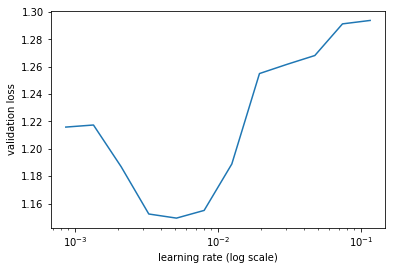

In [57]:
learner.sched.plot()

In [72]:
learner.fit(2e-3, 1, cycle_len=30, wds=0.1, use_wd_sched=True, use_clr_beta=(10,10,0.95,0.85))

 74%|███████▍  | 23/31 [00:05<00:02,  3.87it/s, loss=0.755]
epoch      trn_loss   val_loss   accuracy                  
    0      0.672974   4.090332   0.34357   
    1      0.472505   0.426548   0.846449                  
    2      0.38109    0.419813   0.890595                  
    3      0.304422   0.32947    0.890595                  
    4      0.257997   2.785977   0.520154                  
    5      0.253732   1.980439   0.671785                  
    6      0.234668   2.757795   0.556622                  
    7      0.24611    7.535696   0.387716                  
    8      0.221279   0.516977   0.809981                  
    9      0.200999   1.412755   0.798464                  
    10     0.186776   2.778348   0.71785                   
    11     0.173887   1.544979   0.761996                  
    12     0.192643   0.76138    0.852207                  
    13     0.16577    0.25055    0.932821                  
    14     0.148431   0.415743   0.882917               

[0.039445828104788534, 0.9846449136276392]

In [49]:
x.size()

torch.Size([3, 224, 224])

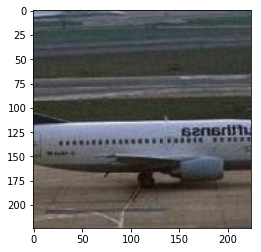

In [54]:
plt.imshow(x.numpy().transpose(1,2,0))

In [ ]:
class DeviceDataLoader1():
    def __init__(self, dl, device, stats):
        self.dl,self.device = dl,device
        self.m, self.s = map(lambda x:torch.tensor(x, dtype=torch.float32, device=device), stats)
        
    def __iter__(self):
        for xb, yb in self.dl:
            xb.add_(-1, self.m[None,:,None,None]).div_(self.s[None,:,None,None])
            yield xb,yb
    
    def __len__(self): return (len(self.dl))

In [ ]:
class DeviceDataLoader1():
    def __init__(self, dl, device, stats):
        self.dl,self.device = DataPrefetcher(dl),device
        self.m, self.s = map(lambda x:torch.tensor(x, dtype=torch.float32, device=device), stats)
        
    def __iter__(self):
        for xb, yb in self.dl:
            xb.add_(-1, self.m[None,:,None,None]).div_(self.s[None,:,None,None])
            yield xb,yb
    
    def __len__(self): return (len(self.dl))

class DataBunch():
    def __init__(self, trn_ds, val_ds, stats, cuda_id, trn_sampler=None, val_sampler=None, bs=64):
        if hasattr(trn_ds, 'classes'): self.classes = trn_ds.classes
        self.trn_dl = get_dataloader(trn_ds, bs, shuffle=(trn_sampler is None), cuda_id=cuda_id, stats=stats, sampler=trn_sampler)
        self.val_dl = get_dataloader(val_ds, bs*2, shuffle=False, cuda_id=cuda_id, stats=stats, sampler=val_sampler)

    @classmethod
    def from_files(cls, Path, trn_tfms, val_tfms, stats, sz, cuda_id, distrib=False, logs=None, trn_name='train', val_name='valid', bs=64):
        trn_ds, val_ds = TransformedFilesDataset(Path/trn_name, sz, trn_tfms), ValTransformedFilesDataset(Path/val_name, sz, val_tfms)
        trn_sampler = DistributedSampler(trn_ds) if distrib else None
        val_sampler = None #DistributedSampler(val_ds) if distrib else None
        return cls(trn_ds, val_ds, stats, cuda_id, trn_sampler, val_sampler, bs)

def init_np(id):
    seed = (torch.initial_seed() + id) % (2**32)
    np.random.seed(seed)

def get_dataloader(ds, bs, shuffle, cuda_id, stats, sampler):
    device = torch.device('cuda', cuda_id)
    dl = DataLoader1(ds, batch_size=bs, shuffle=shuffle,num_workers=8, sampler=sampler, pin_memory=True, worker_init_fn=init_np)
    return DeviceDataLoader1(dl, device, stats)
